In [1]:
!pip install PySpice
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
import pandas as pd #Leer archivos de Excel
from PySpice.Spice.Netlist import *
from PySpice.Unit import *

# Diseño de filtro Butterworth Pasa Bajas

## Paola Briseño, UAM - I, 2022.

Diseño y simulación (teórico/SPICE) de un filtro pasa-bajas con la siguiente especificación:

máxima atenuación en la banda de paso: 0.1 dB
mínima atenuación en la banda de rechazo: 60 dB
fp=100m1 y fr=1000m2 Hz,con m1=5 y m2=6 

In [2]:
def aproximacion_butterworth(Ap, Ar, fp, fr):
# Calcula el orden N y la freuencia de corte fc del filtro pasabajas␣Butterworth, dadas las especificaciones relativas (Ap, fp), (Ar, fr)
  N = int(np.ceil((np.log10((10**(Ap/10)-1)/(10**(Ar/10)-1)))/(2*np.log10(fp/fr))))
  fc = fp/(10**(Ap/10)-1)**(1/(2*N))
  return N, fc

In [3]:
def butterworth_pasabajas(N, fc):
# Calcula los coeficientes b, a del filtro pasabajas Butterworth de orden N y frecuencia
# de corte fc, así como su forma factorizada en la lista s. Cada entrada de s␣ es una sección de primer o segundo orden: s = [[bi, ai], ....]

# Calcula los polos
  p = np.array([np.exp(1j*(2*k-1)*np.pi/(2*N))*(np.exp(-1j*np.pi/2)) for k in range(1, 2*N+1)])
  p = np.array([2*np.pi*fc*pi for pi in p if pi.real <= 0])
# Genera los coeficientes de H(s)
  a = np.poly(p).real
  b = np.array([(2*np.pi*fc)**N])
# Ordena los polos para hacer las secciones
  inx = np.argsort(p.real)
  p = p[inx]
# Inicializa la lista de secciones
  s = []
# Sección de orden uno, si la hay
  if N%2 != 0:
    bi = np.array([-p[0].real])
    ai = np.array([1, -p[0].real])
    s.append([bi, ai])
    # Quita el polo real de la lista
    p = p[1:]
# Secciones de orden dos
  for i in range(0, p.shape[0], 2):
    ai = np.poly(p[i:i+2]).real
    bi = np.array([ai[2]])
    s.append([bi, ai])
  return b, a, s

# Comienza el diseño

In [4]:
# (Paso 1) Especificación relativa
Ap, fp, Ar, fr = 0.1, 100*8, 60, 1000*11
# (Paso 2) Parámetros del filtro
N, fc = aproximacion_butterworth(Ap, Ar, fp, fr)
# (Paso 3) Coeficientes de las secciones
b, a, s = butterworth_pasabajas(N, fc)

In [5]:
#print(b)
print(b[0])
print(a)
print(N)
print(fc)
#print(s)

4182796924477930.5
[1.00000000e+00 2.10148858e+04 2.20812713e+08 1.35912820e+12
 4.18279692e+15]
4
1279.93179224373


Text(0.5, 1.0, 'Pasa-bajas, N=4')

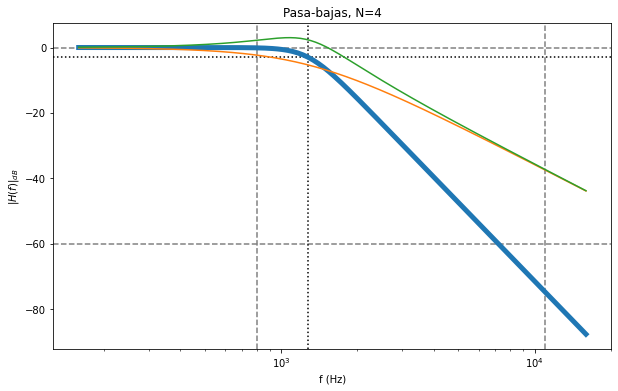

In [8]:
# Prepara gráfica con referencias relevantes (pasa bajas)
plt.figure(figsize=(10, 6))
plt.axhline(-Ap, color='gray', linestyle='--')
plt.axhline(-Ar, color='gray', linestyle='--')
plt.axhline(-3, color='black', linestyle=':')
plt.axvline(fp, color='gray', linestyle='--')
plt.axvline(fr, color='gray', linestyle='--')
plt.axvline(fc, color='black', linestyle=':')
# Respuesta en frecuencia total
W, H = sps.freqs(b, a)
f = W/(2*np.pi)
plt.semilogx(f, 20*np.log10(np.abs(H)), linewidth=5, label='total')
# Respuesta en frecuencia de cada sección
for i, [bi, ai] in enumerate(s):
  _, Hi = sps.freqs(bi, ai, W)
  plt.semilogx(f, 20*np.log10(np.abs(Hi)), label='sección {}'.format(i))
# Documenta la gráfica
plt.xlabel('f (Hz)')
plt.ylabel('$|H(f)|_{dB}$')
plt.title(f'Pasa-bajas, N={N}')

In [9]:
def secciones_sallen_key(s, C=1e-6):
# Calcula los componentes de cada sección, usando como base C3=1uF.Regresa la lista sk = [[R1, R2, C2], [R1i, R2i, C3i, C4i], ....]
# con los␣ componentes de la sección de primer orden (si la hay) y los de las secciones de segundo␣orden

# Inicializa lista de componentes de sección
  sk = []
# Para cada sección
  for i, [bi, ai] in enumerate(s):
# Sección de primer orden
    if ai.shape[0] == 2:
      R = 1/(ai[1]*C)
      print('sección {}: R1={:6.3f}k, R2={:6.3f}k, C2={:6.3f}u'.format(i, R/1e3, R/1e3, C/1e-6))
      sk.append([R/1e3, R/1e3, C/1e-6])
      # Sección de segundo orden
    else:
      m = (ai[1]**2)/(4*ai[2])
      R1 = ai[1]/(2*m*ai[2]*C)
      R2 = ai[1]/(m*ai[2]*C)-R1
      print('sección {}: R1={:6.3f}k, R2={:6.3f}k, C3={:6.3f}u, C4={:6.3f}u'.format(i, R1/1e3, R2/1e3, C/1e-6, m*C/1e-6))
      sk.append([R1/1e3, R2/1e3, C/1e-6, m*C/1e-6])
  return sk

In [10]:
def sallen_key_pasabajas_spice(sk, spiceopus=False):
## Genera una lista de red (netlist) para SPICE a partir de los componentes exactos

# Cadenas paramétricas de elementos del netlist
  MODELOS = '* Modelos\n.include tl081.mod\n'
  SENAL = '* Fuente de señal\nVin (vin 0) dc 0 ac 1.0v\n'
  ALIMENTACION = '* Fuentes de alimentación\nVpp (vp 0) dc 15\nVnn (0 vn) dc 15\n'
  POrc = '*Seccion {0}\nR1{0} ({4} vi{0}) {1}k\nR2{0} (vi{0} {5}) {2}k\nC2{0} (vi{0} {5}) {3}u\n'
  POopamp = 'X{0} (0 vi{0} vp vn {2}) TL081\n'
  SKrc = '*Seccion {0}\nR1{0} ({5} n0{0}) {1}k\nR2{0} (n0{0} vni{0}) {2}k\nC3{0} (n0{0} {6}) {3}u\nC4{0} (vni{0} 0) {4}u\n'
  SKopamp = 'X{0} (vni{0} {1} vp vn {1}) TL081\n'
  CTRL = '* Simulacion\n.control\ndestroy all\nac dec 10 0.1Hz 10MegHz\nplot db(mag(v(vout)/v(vin))) vs frequency\n+ xlabel "f (Hz)"\n+ ylabel "|H(f)|dB"\n.endc\n.end'

# Inicializa el netlist con el encabezado básico
  netlist = MODELOS + SENAL + ALIMENTACION
# Agrega cada sección
  for i, ski in enumerate(sk):
  # Secciones de segundo orden Sallen-Key
    if len(ski) == 4:
      if i == 0:
        netlist = netlist + SKrc.format(i, ski[0], ski[1], ski[2], ski[3], 'vin', 'vout0')
        netlist = netlist + SKopamp.format(i, 'vout0')
      elif i == len(sk)-1:
        netlist = netlist + SKrc.format(i, ski[0], ski[1], ski[2], ski[3], 'vout{}'.format(i-1), 'vout')
        netlist = netlist + SKopamp.format(i, 'vout')
      else:
        netlist = netlist + SKrc.format(i, ski[0], ski[1], ski[2], ski[3], 'vout{}'.format(i-1), 'vout{}'.format(i))
        netlist = netlist + SKopamp.format(i, 'vout{}'.format(i))
# Sección inversora de primer orden
    else:
      if i == 0:
        netlist = netlist + POrc.format(i, ski[0], ski[1], ski[2], 'vin', 'vout0')
        netlist = netlist + POopamp.format(i, 'vin', 'vout0')
      elif i == len(sk)-1:
        netlist = netlist + POrc.format(i, ski[0], ski[1], ski[2], 'vout{}'.format(i-1), 'vout')
        netlist = netlist + POopamp.format(i, 'vout{}'.format(i-1), 'vout')
      else:
        netlist = netlist + POrc.format(i, ski[0], ski[1], ski[2], 'vout{}'.format(i-1), 'vout{}'.format(i))
        netlist = netlist + POopamp.format(i, 'vout{}'.format(i-1), 'vout{}'.format(i))
  # Si se prefiere el netlist para SPICEopus
  if spiceopus:
    netlist = netlist + CTRL
  return netlist

# Continuación de diseño

In [11]:
# (Paso 4) Calcula componentes de las secciones
sk = secciones_sallen_key(s)
# (Paso 5) Simulación realista (SPICE) vs modelo (Python/Octave)
circuit = Circuit('PySPICE')
circuit.raw_spice = sallen_key_pasabajas_spice(sk, spiceopus=True)
sim = circuit.simulator().ac(start_frequency=10@u_Hz, stop_frequency=0.1@u_MHz, number_of_points=10, variation='dec')

sección 0: R1= 0.135k, R2= 0.135k, C3= 1.000u, C4= 0.854u
sección 1: R1= 0.325k, R2= 0.325k, C3= 1.000u, C4= 0.146u


OSError: cannot load library 'C:\Users\ichbi\anaconda3\lib\site-packages\PySpice\Spice\NgSpice\Spice64_dll\dll-vs\ngspice.dll': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'C:\\Users\\ichbi\\anaconda3\\lib\\site-packages\\PySpice\\Spice\\NgSpice\\Spice64_dll\\dll-vs\\ngspice.dll'

In [12]:
sk

[[0.13459160096231393, 0.13459160096231393, 1.0, 0.8535533905932735],
 [0.32493286842472563, 0.32493286842472563, 1.0, 0.14644660940672646]]

In [13]:
import PySpice
PySpice.__version__

'1.5'

In [14]:
# Despliega el netlist SPICE
print(circuit)

.title PySPICE
* Modelos
.include tl081.mod
* Fuente de señal
Vin (vin 0) dc 0 ac 1.0v
* Fuentes de alimentación
Vpp (vp 0) dc 15
Vnn (0 vn) dc 15
*Seccion 0
R10 (vin n00) 0.13459160096231393k
R20 (n00 vni0) 0.13459160096231393k
C30 (n00 vout0) 1.0u
C40 (vni0 0) 0.8535533905932735u
X0 (vni0 vout0 vp vn vout0) TL081
*Seccion 1
R11 (vout0 n01) 0.32493286842472563k
R21 (n01 vni1) 0.32493286842472563k
C31 (n01 vout) 1.0u
C41 (vni1 0) 0.14644660940672646u
X1 (vni1 vout vp vn vout) TL081
* Simulacion
.control
destroy all
ac dec 10 0.1Hz 10MegHz
plot db(mag(v(vout)/v(vin))) vs frequency
+ xlabel "f (Hz)"
+ ylabel "|H(f)|dB"
.endc
.end




# Mediciones de la implementación:

In [15]:
# Extraer ruta del archivo de mediciones
path = 'med_PB.xlsx'
#Datos completos de la tabla:
datos = pd.read_excel(path)
datos

,Frec (Hz),Vin (V),Vout (V),Vout (V)dB
0,200.1,1.14,0.94,-0.537443
1,250.8,1.12,0.94,-0.537443
2,301.1,1.16,0.92,-0.724243
3,350.9,1.14,0.90,-0.915150
4,401.1,1.14,0.88,-1.110347
5,499.0,1.12,0.86,-1.310031
6,607.0,1.14,0.78,-2.158108
7,710.7,1.12,0.74,-2.615366
8,857.6,1.08,0.70,-3.098039
9,952.9,1.06,0.66,-3.609121


In [16]:
# Extraer ruta del archivo de mediciones Spice
path = 'PB_spice.xlsx'
#Datos completos de la tabla:
spice = pd.read_excel(path)
#spice
spice

,Frec (Hz),Vin (V),Vout(V),Vout (V)dB
0,50.440,1,NaN,0.0225
1,99.960,1,NaN,0.0225
2,155.340,1,NaN,0.0225
3,204.230,1,NaN,0.0225
4,252.690,1,NaN,0.0225
5,303.220,1,NaN,0.1440
6,404.760,1,NaN,0.0225
7,508.420,1,NaN,0.0225
8,600.900,1,NaN,0.0225
9,802.180,1,NaN,0.0225


Text(0.5, 1.0, 'Pasa-Bajas, N=4')

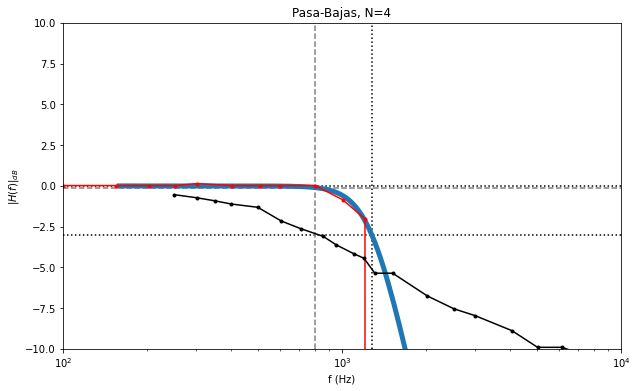

In [22]:
# Prepara gráfica con referencias relevantes (pasa bajas)
plt.figure(figsize=(10, 6))
plt.axhline(-Ap, color='gray', linestyle='--')
plt.axhline(-Ar, color='gray', linestyle='--')
plt.axhline(-3, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axvline(fp, color='gray', linestyle='--')
plt.axvline(fr, color='gray', linestyle='--')
plt.axvline(fc, color='black', linestyle=':')

# Respuesta en frecuencia total
W, H = sps.freqs(b, a)
f = W/(2*np.pi)
plt.semilogx(f, 20*np.log10(np.abs(H)), linewidth=5, label='total')

#Gráfica de las mediciones en la simulación spice
f_spice = spice.iloc[1:, 0]
H_spice = spice.iloc[1:, 3]
plt.semilogx(f_spice, H_spice, color='red', linestyle='-', marker='.', label='SPICE')
plt.axis([100, 10000, -10, 10])

#Gráfica de las mediciones en la implementación
f_med = datos.iloc[1:, 0]
H_med = datos.iloc[1:, 3]
plt.semilogx(f_med, H_med, color='black', linestyle='-', marker='.', label='MEDICIONES')
plt.axis([100, 10000, -10, 10])

# Documenta la gráfica
plt.xlabel('f (Hz)')
plt.ylabel('$|H(f)|_{dB}$')
plt.title(f'Pasa-Bajas, N={N}')